# To perform multi-classifier SVM for reconstructed feature (HG) using FA in four targets. Check accuracy for the common space and private space 


# Organzing and loading the data for all related days 

In [113]:
# clean the memory 


# loading the library
import numpy as np
import os
import os.path
import scipy.io
from scipy.io import loadmat
import pickle
import hdf5storage as hdf5s
import h5py

# Experiment info 
# loading the imagined data

# initilize the values
class structtype():
    pass

ExptDays = list(['20201002','20201009','20201016','20201030','20201113','20201117','20201118'])
NumDay = len(ExptDays);
SessionDay = [ structtype() for i in range(NumDay)]
SessionDay[0].hhmmss = list(['145058','145910','150443','151528','152108'])
SessionDay[1].hhmmss = list(['134342','134836','135450','135947'])
SessionDay[2].hhmmss = list(['142924','144138','144924'])
SessionDay[3].hhmmss = list(['133902','134541','134838','141625','142426'])
SessionDay[4].hhmmss = list(['134350','135330','135938','140554'])
SessionDay[5].hhmmss = list(['111747','112508','113040','141009'])
SessionDay[6].hhmmss = list(['140255','140540'])

# for reading mat file from matlab
# it is easier to use class for further extracting necessary params or data
class MatFileAnalyzer():
    
    # first mandatory method; constructor
    def __init__(self,Mat_data):
        self.Fs = Mat_data['TrialData']['Params']['Fs'][0][0]
        self.UpdateRate = Mat_data['TrialData']['Params']['UpdateRate'][0][0]
        self.TargetID = Mat_data['TrialData']['TargetID'][0][0]
        self.SelectedTargetID = Mat_data['TrialData']['SelectedTargetID'][0][0]
        self.MaxReachTime = Mat_data['TrialData']['Params']['MaxReachTime'][0][0]
        self.Click_BinNum = Mat_data['TrialData']['Params']['ClickCounter'][0][0]
        
    def ECoG_Raw(self):
        
        Signals = Mat_data['TrialData']['BroadbandData']
        BinNum = Signals.shape[0]
        ECoGData = np.empty((0,128), dtype=float)
        for i in range(BinNum):
            Bin = Mat_data['TrialData']['BroadbandData'][i][0]
            BinName = h5py.h5r.get_name(Bin, Mat_data.id)
            BinInfo = Mat_data[BinName] 
            BinData = BinInfo[:,:]
            ECoGData = np.concatenate((ECoGData, BinData.T), axis=0)

        return ECoGData
    
    def Features_All(self):
        
        Features = Mat_data['TrialData']['NeuralFeatures']
        BinNum = Features.shape[0]
        NeuralFeatures = np.empty((0,896), dtype=float)
        
        if ExptDays[Day] == '20201002':
            
            for i in range(BinNum-int(self.Click_BinNum),BinNum,1):
                Bin = Mat_data['TrialData']['NeuralFeatures'][i][0]
                BinName = h5py.h5r.get_name(Bin, Mat_data.id)
                BinInfo = Mat_data[BinName] 
                BinData = BinInfo[:,:]
                NeuralFeatures = np.concatenate((NeuralFeatures, BinData), axis=0)
                
            return NeuralFeatures
        
        else:
                        
            BinControl = [] 
            for i in range(BinNum):
                if Mat_data['TrialData']['TaskState'][i][0] == 3:
                    BinControl.append(i)
             
            for j in BinControl[-int(TrialData.Click_BinNum):]:
                if ExptDays[Day] == '20201009':
                    j=j-1
                    
                Bin = Mat_data['TrialData']['NeuralFeatures'][j][0]
                BinName = h5py.h5r.get_name(Bin, Mat_data.id)
                BinInfo = Mat_data[BinName] 
                BinData = BinInfo[:,:]
                NeuralFeatures = np.concatenate((NeuralFeatures, BinData), axis=0)
                
            return NeuralFeatures
        
    def SmoothedFeatures_All(self):
        
        Features = Mat_data['TrialData']['SmoothedNeuralFeatures']
        BinNum = Features.shape[0]
        SmoothedNeuralFeatures = np.empty((0,896), dtype=float)
                  
        BinControl = [] 
        for i in range(BinNum):
            if Mat_data['TrialData']['TaskState'][i][0] == 3:
                BinControl.append(i)

        for j in BinControl[-int(TrialData.Click_BinNum):]:
            if ExptDays[Day] == '20201009':
                j=j-1

            Bin = Mat_data['TrialData']['SmoothedNeuralFeatures'][j][0]
            BinName = h5py.h5r.get_name(Bin, Mat_data.id)
            BinInfo = Mat_data[BinName] 
            BinData = BinInfo[:,:]
            SmoothedNeuralFeatures = np.concatenate((SmoothedNeuralFeatures, BinData), axis=0)

        return SmoothedNeuralFeatures   


Trials_T1 = np.empty((0,896), dtype=float)
Trials_T2 = np.empty((0,896), dtype=float)
Trials_T3 = np.empty((0,896), dtype=float)
Trials_T4 = np.empty((0,896), dtype=float)

# numnber of censequative bins for making correct selections
Click_BinNum_T1 = []
Click_BinNum_T2 = []
Click_BinNum_T3 = []
Click_BinNum_T4 = []

Day_NumTrial_T1 = []
Day_NumTrial_T2 = []
Day_NumTrial_T3 = []
Day_NumTrial_T4 = []


# loading the day/block/session data from the location
# day 0 does not have SmoothedNeuralFeatures
# day 6 the performance was not good
for Day in [ 1, 2, 3, 4, 5, 6]:
    ID1 = 0;
    ID2 = 0;
    ID3 = 0;
    ID4 = 0;

    for Se in range (len(SessionDay[Day].hhmmss)):

        print('Session:'+ SessionDay[Day].hhmmss[Se])
        # in windows
        if ExptDays[Day] in ['20201002','20201009']:
            DataPath =os.path.join('E:','\BRAVO1','CursorPlatform','Data',ExptDays[Day],'GangulyServer',ExptDays[Day],'RadialTask',SessionDay[Day].hhmmss[Se],'BCI_Fixed')
        
        else:
            DataPath =os.path.join('E:','\BRAVO1','CursorPlatform','Data',ExptDays[Day],'GangulyServer',ExptDays[Day],'DiscreteArrow',SessionDay[Day].hhmmss[Se],'BCI_Fixed')
        
        datadir = os.listdir(DataPath)

        # loading the trials
        for k in range(len(datadir)):

            print('Trial:',k+1)
            Mat_data = h5py.File(DataPath+'/'+datadir[k])
            TrialData = MatFileAnalyzer(Mat_data)
            ECoG1 = TrialData.ECoG_Raw()
            Fs = TrialData.Fs
            LenSignal = ECoG1.shape[0]
            MaxReachTime = TrialData.MaxReachTime

            # to find successful trials
            if ExptDays[Day] == '20201002' and ((LenSignal/Fs) < (MaxReachTime)):
                #print(True)
                NeuralFeatures = TrialData.Features_All()

                if TrialData.TargetID == 1:
                    ID1 = ID1+1                   
                    Trials_T1 = np.append(Trials_T1, NeuralFeatures, axis=0)

                elif TrialData.TargetID == 2:
                    ID2 = ID2+1
                    Trials_T2 = np.append(Trials_T2,NeuralFeatures, axis=0)

                elif TrialData.TargetID == 3:
                    ID3 = ID3+1
                    Trials_T3 = np.append(Trials_T3, NeuralFeatures, axis=0)

                elif TrialData.TargetID == 4:
                    ID4 = ID4+1
                    Trials_T4 = np.append(Trials_T4, NeuralFeatures, axis=0)

            elif ExptDays[Day] != '20201002' and TrialData.SelectedTargetID == TrialData.TargetID:
                #print(True)
                NeuralFeatures = TrialData.Features_All()
                SmoothedNeuralFeatures = TrialData.SmoothedFeatures_All()
                
                if TrialData.TargetID == 1:
                    ID1 = ID1+1                   
                    Trials_T1 = np.append(Trials_T1, SmoothedNeuralFeatures, axis=0)
                    Click_BinNum_T1.append(TrialData.Click_BinNum)

                elif TrialData.TargetID == 2:
                    ID2 = ID2+1
                    Trials_T2 = np.append(Trials_T2, SmoothedNeuralFeatures, axis=0)
                    Click_BinNum_T2.append(TrialData.Click_BinNum)

                elif TrialData.TargetID == 3:
                    ID3 = ID3+1
                    Trials_T3 = np.append(Trials_T3, SmoothedNeuralFeatures, axis=0)
                    Click_BinNum_T3.append(TrialData.Click_BinNum)

                elif TrialData.TargetID == 4:
                    ID4 = ID4+1
                    Trials_T4 = np.append(Trials_T4, SmoothedNeuralFeatures, axis=0)
                    Click_BinNum_T4.append(TrialData.Click_BinNum)
                    
    Day_NumTrial_T1.append(ID1)
    Day_NumTrial_T2.append(ID2)
    Day_NumTrial_T3.append(ID3)
    Day_NumTrial_T4.append(ID4)
    

print('End of Running Section')  

                      

Session:134342
Trial: 1
Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Session:134836
Trial: 1
Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Trial: 9
Trial: 10
Trial: 11
Trial: 12
Trial: 13
Trial: 14
Trial: 15
Trial: 16
Trial: 17
Trial: 18
Trial: 19
Trial: 20
Trial: 21
Trial: 22
Trial: 23
Trial: 24
Trial: 25
Trial: 26
Trial: 27
Trial: 28
Trial: 29
Trial: 30
Session:135450
Trial: 1
Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Trial: 9
Trial: 10
Trial: 11
Trial: 12
Trial: 13
Trial: 14
Trial: 15
Trial: 16
Trial: 17
Trial: 18
Trial: 19
Trial: 20
Trial: 21
Trial: 22
Trial: 23
Trial: 24
Trial: 25
Trial: 26
Trial: 27
Trial: 28
Trial: 29
Trial: 30
Session:135947
Trial: 1
Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Trial: 9
Trial: 10
Trial: 11
Trial: 12
Trial: 13
Trial: 14
Trial: 15
Trial: 16
Trial: 17
Trial: 18
Trial: 19
Trial: 20
Trial: 21
Trial: 22
Trial: 23
Trial: 24
Trial: 25
Trial: 26
Trial: 27
Trial: 28
Trial: 29
Trial

In [114]:
Day_NumTrial_T1

[25, 21, 37, 31, 31]

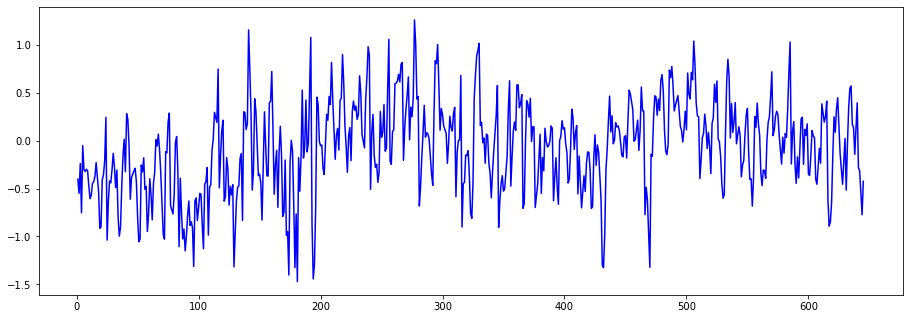

In [115]:
# plot one example of HG feature
import matplotlib.pyplot as plt
%matplotlib inline
t_bin = np.arange(1,Trials_T4.shape[0]+1,1)
fig = plt.figure(figsize=(12,4))
ax = fig.add_axes([0,0,1,1])
ax.plot(t_bin,Trials_T4[:,800],'b')

# plot of ERP for engaged sequential bins per day and per target

In [116]:
#choose HG
Fe = 7
HG_T1 = Trials_T1[:,128*(Fe-1):128*Fe]
HG_T2 = Trials_T2[:,128*(Fe-1):128*Fe]
HG_T3 = Trials_T3[:,128*(Fe-1):128*Fe]
HG_T4 = Trials_T4[:,128*(Fe-1):128*Fe]

# for target 1
# initilize the values
class structtype():
    pass

SingleTrials_T1 = [ structtype() for i in range(len(Day_NumTrial_T1))]
ERP_T1 = [ structtype() for i in range(len(Day_NumTrial_T1))]

BinNum_ERP = int(max(Click_BinNum_T1))
for i in range(len(Day_NumTrial_T1)):
    Temp = np.empty((BinNum_ERP,128,Day_NumTrial_T1[i]), dtype=float)
    Temp[:]=np.nan 

    for j in range(Day_NumTrial_T1[i]):
        if j == 0:
            Temp[0:int(Click_BinNum_T1[j]),:,j] = HG_T1[0:int(Click_BinNum_T1[j]),:]
            
    
        else:
            Temp[0:int(Click_BinNum_T1[j]),:,j] = HG_T1[int(sum(Click_BinNum_T1[0:(j-1)])):int(sum(Click_BinNum_T1[0:(j-1)]))+int(Click_BinNum_T1[j]),:]
            
    SingleTrials_T1[i].Day = Temp
    ERP_T1[i].Day = np.nanmean(Temp, axis=2)

# for target 2
# initilize the values
class structtype():
    pass

SingleTrials_T2 = [ structtype() for i in range(len(Day_NumTrial_T2))]
ERP_T2 = [ structtype() for i in range(len(Day_NumTrial_T2))]

BinNum_ERP = int(max(Click_BinNum_T2))
for i in range(len(Day_NumTrial_T2)):
    Temp = np.empty((BinNum_ERP,128,Day_NumTrial_T2[i]), dtype=float)
    Temp[:]=np.nan  

    for j in range(Day_NumTrial_T2[i]):
        if j == 0:
            Temp[0:int(Click_BinNum_T2[j]),:,j] = HG_T2[0:int(Click_BinNum_T2[j]),:]
            
    
        else:
            Temp[0:int(Click_BinNum_T1[j]),:,j] = HG_T2[int(sum(Click_BinNum_T2[0:(j-1)])):int(sum(Click_BinNum_T2[0:(j-1)]))+int(Click_BinNum_T2[j]),:]
            
    SingleTrials_T2[i].Day = Temp
    ERP_T2[i].Day = np.nanmean(Temp, axis=2)
    
# for target 3
# initilize the values
class structtype():
    pass

SingleTrials_T3 = [ structtype() for i in range(len(Day_NumTrial_T3))]
ERP_T3 = [ structtype() for i in range(len(Day_NumTrial_T3))]

BinNum_ERP = int(max(Click_BinNum_T3))
for i in range(len(Day_NumTrial_T3)):
    Temp = np.empty((BinNum_ERP,128,Day_NumTrial_T3[i]), dtype=float)
    Temp[:]=np.nan 

    for j in range(Day_NumTrial_T3[i]):
        if j == 0:
            Temp[0:int(Click_BinNum_T3[j]),:,j] = HG_T3[0:int(Click_BinNum_T3[j]),:]
            
    
        else:
            Temp[0:int(Click_BinNum_T3[j]),:,j] = HG_T3[int(sum(Click_BinNum_T3[0:(j-1)])):int(sum(Click_BinNum_T3[0:(j-1)]))+int(Click_BinNum_T3[j]),:]
            
    SingleTrials_T3[i].Day = Temp
    ERP_T3[i].Day = np.nanmean(Temp, axis=2)
    
# for target 4
# initilize the values
class structtype():
    pass

SingleTrials_T4 = [ structtype() for i in range(len(Day_NumTrial_T4))]
ERP_T4 = [ structtype() for i in range(len(Day_NumTrial_T4))]

BinNum_ERP = int(max(Click_BinNum_T4))
for i in range(len(Day_NumTrial_T4)):
    Temp = np.empty((BinNum_ERP,128,Day_NumTrial_T4[i]), dtype=float)
    Temp[:]=np.nan 

    for j in range(Day_NumTrial_T4[i]):
        if j == 0:
            Temp[0:int(Click_BinNum_T4[j]),:,j] = HG_T4[0:int(Click_BinNum_T4[j]),:]
            
    
        else:
            Temp[0:int(Click_BinNum_T4[j]),:,j] = HG_T4[int(sum(Click_BinNum_T4[0:(j-1)])):int(sum(Click_BinNum_T4[0:(j-1)]))+int(Click_BinNum_T4[j]),:]
            
    SingleTrials_T4[i].Day = Temp
    ERP_T4[i].Day = np.nanmean(Temp, axis=2)
    


<ipython-input-116-f91a43de9724>:30: RuntimeWarning: Mean of empty slice
  ERP_T1[i].Day = np.nanmean(Temp, axis=2)
<ipython-input-116-f91a43de9724>:54: RuntimeWarning: Mean of empty slice
  ERP_T2[i].Day = np.nanmean(Temp, axis=2)
<ipython-input-116-f91a43de9724>:78: RuntimeWarning: Mean of empty slice
  ERP_T3[i].Day = np.nanmean(Temp, axis=2)
<ipython-input-116-f91a43de9724>:102: RuntimeWarning: Mean of empty slice
  ERP_T4[i].Day = np.nanmean(Temp, axis=2)


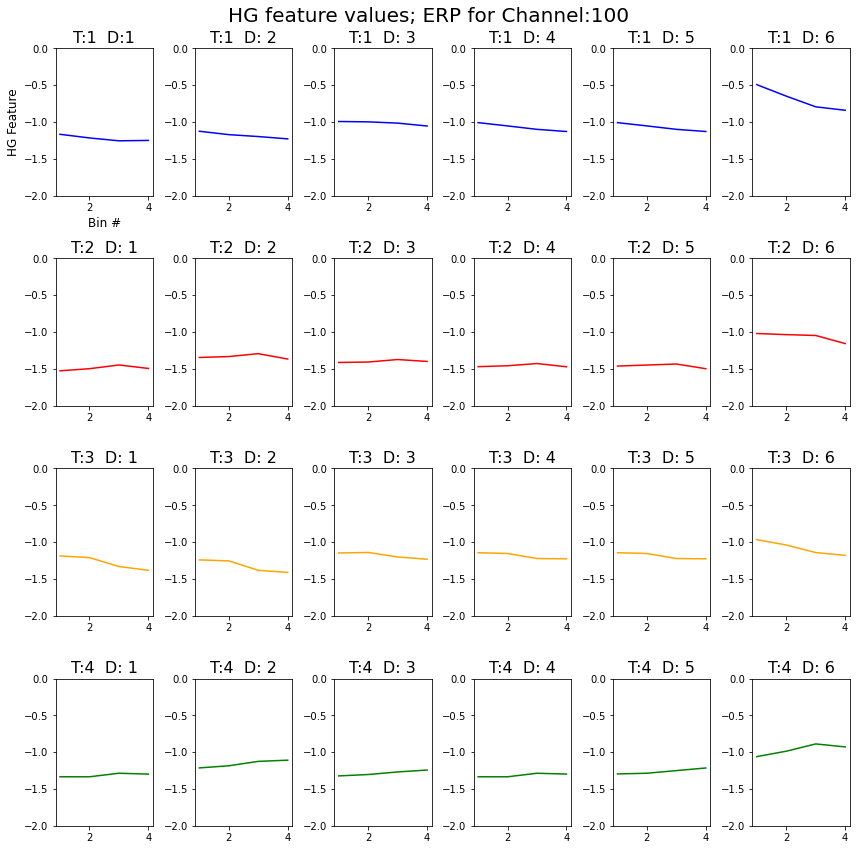

In [6]:
# plot the ERP for a chosen channel 

%matplotlib inline

ListMarker = ['blue','red','orange','green']
ch = 100

fig, axes = plt.subplots(4,6,figsize=(12,12))
fig.suptitle('HG feature values; ERP for Channel:'+str(ch), fontsize=20)

ERP_All = [ERP_T1, ERP_T2, ERP_T3, ERP_T4]

for target in range(4):
    ERP_AllDay = ERP_All[target]
    
    for ax in range(6):
        ERP_plot = ERP_AllDay[ax].Day
        t_bin = np.arange(1,ERP_plot.shape[0]+1,1)
        if target == 0 and ax == 0:
            axes[target, ax].plot(t_bin,ERP_plot[:,ch],color=ListMarker[target])
            axes[target, ax].set_title('T:'+str(target+1)+'  D:'+str(ax+1),fontsize=16)
            axes[target, ax].set_xlabel('Bin #',fontsize=12)
            axes[target, ax].set_ylabel('HG Feature',fontsize=12)
            axes[target, ax].set_ylim([-2,0])
            
        else:
            axes[target, ax].plot(t_bin,ERP_plot[:,ch],color=ListMarker[target])
            axes[target, ax].set_title('T:'+str(target+1)+'  D: '+str(ax+1),fontsize=16)
            axes[target, ax].set_ylim([-2,0])
            
plt.tight_layout()
#plt.savefig('ERP_Bins_hg_6Days_Ch100.png',dpi=300)







# Selecting the feature and input values for FA analysis

In [117]:

# choose this option
Case = 1 
# 1: is pure feature of HG and concatanated of all trials and targets; 
# 2: is a single value of HG per trial then concatanated of all trials and targets;  

if Case == 1:
    HG_Cat = np.concatenate((HG_T1, HG_T2, HG_T3, HG_T4), axis=0)
    HG_CatTarget_Mean = np.nanmean(HG_CatTarget, axis=0)
    HG_CatTarget = HG_Cat-HG_CatTarget_Mean
    
elif Case == 2:
    
    PointTrials_T1 = np.empty((0,128), dtype=float)
    for i in range(6):
        Temp1 = SingleTrials_T1[i].Day 
        Temp2 = np.nanmean(Temp1, axis=0)
        PointTrials_T1 = np.append(PointTrials_T1, Temp2.T, axis=0)

    PointTrials_T2 = np.empty((0,128), dtype=float)
    for i in range(6):
        Temp1 = SingleTrials_T2[i].Day 
        Temp2 = np.nanmean(Temp1, axis=0)
        PointTrials_T2 = np.append(PointTrials_T2, Temp2.T, axis=0)

    PointTrials_T3 = np.empty((0,128), dtype=float)
    for i in range(6):
        Temp1 = SingleTrials_T3[i].Day 
        Temp2 = np.nanmean(Temp1, axis=0)
        PointTrials_T3 = np.append(PointTrials_T3, Temp2.T, axis=0)

    PointTrials_T4 = np.empty((0,128), dtype=float)
    for i in range(6):
        Temp1 = SingleTrials_T4[i].Day 
        Temp2 = np.nanmean(Temp1, axis=0)
        PointTrials_T4 = np.append(PointTrials_T4, Temp2.T, axis=0)
    
    HG_Cat = np.concatenate((PointTrials_T1, PointTrials_T2, PointTrials_T3, PointTrials_T4), axis=0)
    HG_CatTarget_Mean = np.nanmean(HG_CatTarget, axis=0)
    HG_CatTarget = HG_Cat-HG_CatTarget_Mean      


HG_Cat.shape
HG_CatTarget.mean(axis=0)

array([-7.54357399e-02, -7.80809346e-04,  7.08823808e-01, -1.61053580e-03,
       -1.49131208e-01,  2.48765922e-02, -1.45754708e-02,  4.63040954e-02,
        7.32967863e-01,  1.10061574e-01,  1.32942234e-02,  5.33579540e-02,
        1.22716500e-01, -4.46061875e-02,  1.54849689e-01, -1.14098839e-01,
       -4.47739322e-02, -9.33471142e-02, -2.95630154e-01,  1.99955177e-02,
        7.10140654e-02, -7.12536890e-02,  3.41444480e-02, -2.16034451e-01,
        9.29688831e-01,  6.41231714e-01,  6.43561908e-01, -4.00301091e-02,
        3.08863023e-01,  3.40700052e-02,  8.40229252e-01,  5.34035581e-01,
       -3.26496791e-02,  5.88776191e-01, -8.12240537e-03,  7.83256688e-01,
       -3.18521068e-01,  5.99559814e-02, -5.88150646e-02,  8.29592793e-01,
        8.53987836e-01,  4.26172780e-01,  3.08796309e-02, -3.78647898e-01,
       -3.51156735e-01,  8.03215776e-01,  3.78139974e-02, -1.33355074e-01,
        4.82532890e-03, -1.96212464e-02,  5.70681598e-01, -2.44929260e-02,
       -2.27534389e-01, -

# preliminary anlaysis for FA

pvalue:0.0
kmo_model:0.9855564146763918


C:\Users\test\.conda\envs\SVMforLowDim\lib\site-packages\factor_analyzer\utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


[5.10531535e+01 1.19684938e+01 5.82653735e+00 3.81836128e+00
 2.99353957e+00 2.45101041e+00 2.11766211e+00 1.98061491e+00
 1.73737221e+00 1.46304047e+00 1.30566482e+00 1.23502521e+00
 1.17716738e+00 1.04965235e+00 9.23845250e-01 9.15291633e-01
 8.56992162e-01 8.26269655e-01 8.03116703e-01 7.91419450e-01
 7.51058032e-01 7.33688466e-01 7.10205877e-01 6.90636771e-01
 6.75402166e-01 6.62875990e-01 6.43172228e-01 6.19163191e-01
 6.15835936e-01 6.09344799e-01 5.95064929e-01 5.91513711e-01
 5.80396690e-01 5.57072200e-01 5.54466918e-01 5.45459920e-01
 5.34242139e-01 5.21428664e-01 5.07469193e-01 5.04087347e-01
 4.99797849e-01 4.91319362e-01 4.81363682e-01 4.78221537e-01
 4.60927330e-01 4.56688828e-01 4.50946676e-01 4.32877880e-01
 4.30998853e-01 4.25717753e-01 4.12253504e-01 4.04097058e-01
 3.97546320e-01 3.90327503e-01 3.86506688e-01 3.82045095e-01
 3.76747274e-01 3.67537293e-01 3.66340665e-01 3.50878271e-01
 3.46912324e-01 3.43791337e-01 3.34354989e-01 3.32468997e-01
 3.29333131e-01 3.110255

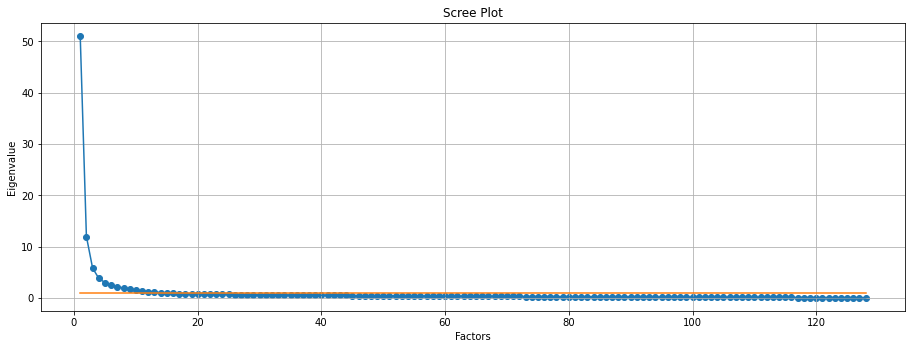

In [118]:
from sklearn.decomposition import FactorAnalysis
from factor_analyzer import FactorAnalyzer
import pandas as pd
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

# check the “factorability” of our dataset

#artlett’s test: the p_value should be statistically significant
chi_square_value,p_value=calculate_bartlett_sphericity(HG_CatTarget)
print('pvalue:'+str(p_value))

# Kaiser-Meyer-Olkin (KMO) Test: Value of KMO less than 0.6 is considered inadequate. should be more than 0.6
kmo_all,kmo_model=calculate_kmo(HG_CatTarget)
print('kmo_model:'+str(kmo_model))

# calcuate the number of necessary factors
fa = FactorAnalyzer(128,rotation=None)
fa.fit(HG_CatTarget)

# Check Eigenvalues; the number of bigger than 1 is good; here 14
ev, v = fa.get_eigenvalues()
print (ev)

# Create scree plot using matplotlib
fig = plt.figure(figsize=(12,4))
ax = fig.add_axes([0,0,1,1])
ax.scatter(range(1,HG_CatTarget.shape[1]+1),ev)
ax.plot(range(1,HG_CatTarget.shape[1]+1),ev)
ax.plot(range(1,HG_CatTarget.shape[1]+1),[1]*128,'-')
ax.set_title('Scree Plot')
ax.set_xlabel('Factors')
ax.set_ylabel('Eigenvalue')
ax.grid()




# Factor Analysis for concatanated single-trials for all targets

In [119]:
from sklearn.decomposition import FactorAnalysis
from factor_analyzer import FactorAnalyzer
import pandas as pd

# initilize the values
class structtype():
    pass
# for FA signals
FASignal = [ structtype() for i in range(4)]

fa = FactorAnalyzer(10,rotation=None)
fa.fit(HG_CatTarget)
FAWeight = fa.loadings_
if Case ==1:
    FASignal[0].Target = (HG_T1-HG_CatTarget_Mean)@ (FAWeight)
    FASignal[1].Target = (HG_T2-HG_CatTarget_Mean)@ (FAWeight)
    FASignal[2].Target = (HG_T3-HG_CatTarget_Mean)@ (FAWeight)
    FASignal[3].Target = (HG_T4-HG_CatTarget_Mean)@ (FAWeight)
    
elif Case ==2:
    FASignal[0].Target = (PointTrials_T1)@ (FAWeight)
    FASignal[1].Target = (PointTrials_T2)@ (FAWeight)
    FASignal[2].Target = (PointTrials_T3)@ (FAWeight)
    FASignal[3].Target = (PointTrials_T4)@ (FAWeight)

        
# Get variance of each factors
fa.get_factor_variance()
# first row: SS Loadings
# second row: Proportion Var per factor
# third row: Cumulative Var up to that factor

(array([50.74477066, 11.74609658,  5.42998631,  3.42342145,  2.58160894,
         2.03687369,  1.68868732,  1.57346684,  1.29973669,  1.1066014 ]),
 array([0.39644352, 0.09176638, 0.04242177, 0.02674548, 0.02016882,
        0.01591308, 0.01319287, 0.01229271, 0.01015419, 0.00864532]),
 array([0.39644352, 0.4882099 , 0.53063167, 0.55737715, 0.57754597,
        0.59345904, 0.60665191, 0.61894462, 0.62909882, 0.63774414]))

In [120]:
Activation_Signal = FASignal[0].Target
FAWeight.shape


(128, 10)

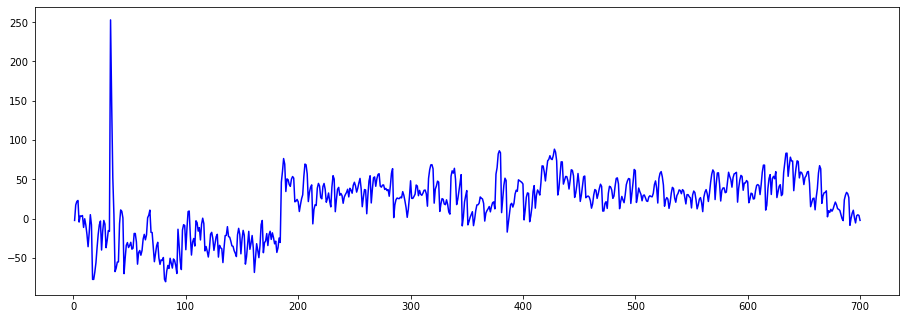

In [51]:
# test the factors
%matplotlib inline
Activation_Signal =FASignal[0].Target
t_bin = np.arange(1,Activation_Signal.shape[0]+1,1)
fig = plt.figure(figsize=(12,4))
ax = fig.add_axes([0,0,1,1])
ax.plot(t_bin,Activation_Signal[:,0],'b')
#ax.set_xlim([0,1])
#ax.set_ylim([0,2])


In [53]:

# 3D plot for the first 3 FA signals; choose the options 
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.animation as animation

%matplotlib auto 

%matplotlib qt
%matplotlib notebook

matplotlib.rcParams.update({'font.size': 18})

ax = plt.axes(projection='3d')
ax.set_xlabel('Dim1')
ax.set_ylabel('Dim2')
ax.set_zlabel('Dim3')
#ax.set_xlim([0,15])
#ax.set_ylim([-5,5])
#ax.set_zlim([-5,5])

ListMarker = ['blue','red','orange','green']
ListLegend = ['Target1','Target2','Target3','target4']

for target in range(4):
    
    # Data for a three-dimensional line
    Activation_Signal = FASignal[target].Target
    xline = Activation_Signal[:,0]
    yline = Activation_Signal[:,1]
    zline = Activation_Signal[:,2]
    ax.plot3D(xline, yline, zline,color=ListMarker[target], label=ListLegend[target])
    
plt.show()
ax.legend(loc=0,fontsize=20)

# for only rotation
"""
# rotate the axes and update
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)
"""


Using matplotlib backend: Qt5Agg


'\n# rotate the axes and update\nfor angle in range(0, 360):\n    ax.view_init(30, angle)\n    plt.draw()\n    plt.pause(.001)\n'

In [ ]:

# creating a fig of 3D plot for the first 3 FA signals; choose the options 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

%matplotlib auto 

%matplotlib qt
%matplotlib notebook

matplotlib.rcParams.update({'font.size': 18})

# Create a figure and a 3D Axes
fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlabel('Dim1')
ax.set_ylabel('Dim2')
ax.set_zlabel('Dim3')
#ax.set_xlim([0,15])
#ax.set_ylim([-5,5])
#ax.set_zlim([-5,5])

ListMarker = ['blue','red','orange','green']
ListLegend = ['Target1','Target2','Target3','target4']

def init():
    for target in range(4):
        # Data for a three-dimensional line
        Activation_Signal = FASignal[target].Target
        xline = Activation_Signal[:,0]
        yline = Activation_Signal[:,1]
        zline = Activation_Signal[:,2]
        ax.plot3D(xline, yline, zline,color=ListMarker[target], label=ListLegend[target])
    
    plt.show()
    ax.legend(loc='upper right',fontsize=10)

    return fig,

def animate(i):
    ax.view_init(elev=10., azim=i)
    return fig,

# Animate
#anim = animation.FuncAnimation(fig, animate, init_func=init, frames=360, interval=20, blit=True)
# Save
#anim.save('rotation.gif', dpi=80, writer='imagemagick')
#anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])


# Plot all latent factors for all targets across bins and days

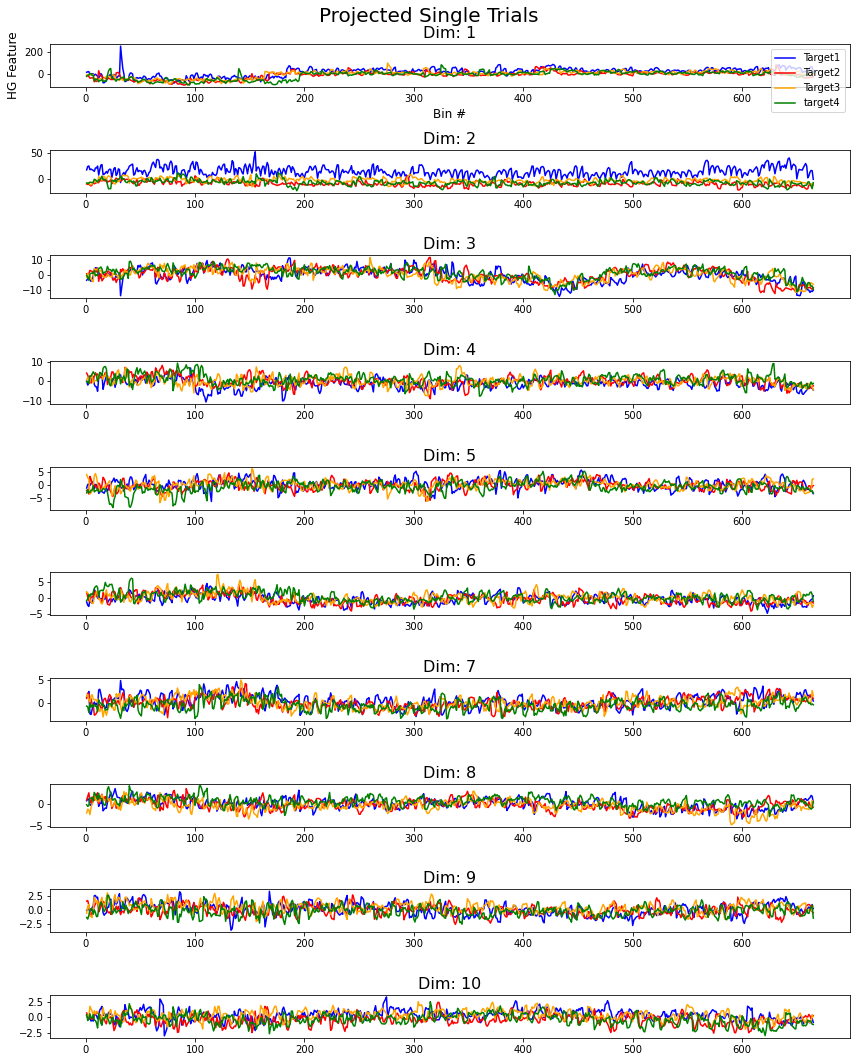

In [54]:

%matplotlib inline
# for plotting purpose
if Case == 1:
    Min_BinNum =min([Trials_T1.shape[0], Trials_T2.shape[0], Trials_T3.shape[0], Trials_T4.shape[0]])

elif Case == 2:
    Min_BinNum =min([PointTrials_T1.shape[0], PointTrials_T2.shape[0], PointTrials_T3.shape[0], PointTrials_T4.shape[0]])

ListMarker = ['blue','red','orange','green']
ListLegend = ['Target1','Target2','Target3','target4']

fig, axes = plt.subplots(10,1,figsize=(12,15))
fig.suptitle('Projected Single Trials', fontsize=20)

for target in range(4):
    Activation_Signal = FASignal[target].Target
    t_bin = np.arange(1,Min_BinNum,1)
    
    for ax in range(axes.shape[0]):
        if ax == 0:
            axes[ax].plot(t_bin,Activation_Signal[1:Min_BinNum,ax],color=ListMarker[target], label=ListLegend[target])
            axes[ax].set_title('Dim: '+str(ax+1),fontsize=16)
            axes[ax].set_xlabel('Bin #',fontsize=12)
            axes[ax].set_ylabel('HG Feature',fontsize=12)
            
        else:
            axes[ax].plot(t_bin,Activation_Signal[1:Min_BinNum,ax],color=ListMarker[target])
            axes[ax].set_title('Dim: '+str(ax+1),fontsize=16)
                
            
axes[0].legend(loc=1)
plt.tight_layout()
#plt.savefig('FA_hg_Points_6Days.png',dpi=300)



# plot of ERP for engaged sequential bins of FA per day and per target

<ipython-input-62-fde9a876d3ee>:31: RuntimeWarning: Mean of empty slice
  ERP_T1[i].Day = np.nanmean(Temp, axis=2)
<ipython-input-62-fde9a876d3ee>:55: RuntimeWarning: Mean of empty slice
  ERP_T2[i].Day = np.nanmean(Temp, axis=2)
<ipython-input-62-fde9a876d3ee>:79: RuntimeWarning: Mean of empty slice
  ERP_T3[i].Day = np.nanmean(Temp, axis=2)
<ipython-input-62-fde9a876d3ee>:103: RuntimeWarning: Mean of empty slice
  ERP_T4[i].Day = np.nanmean(Temp, axis=2)


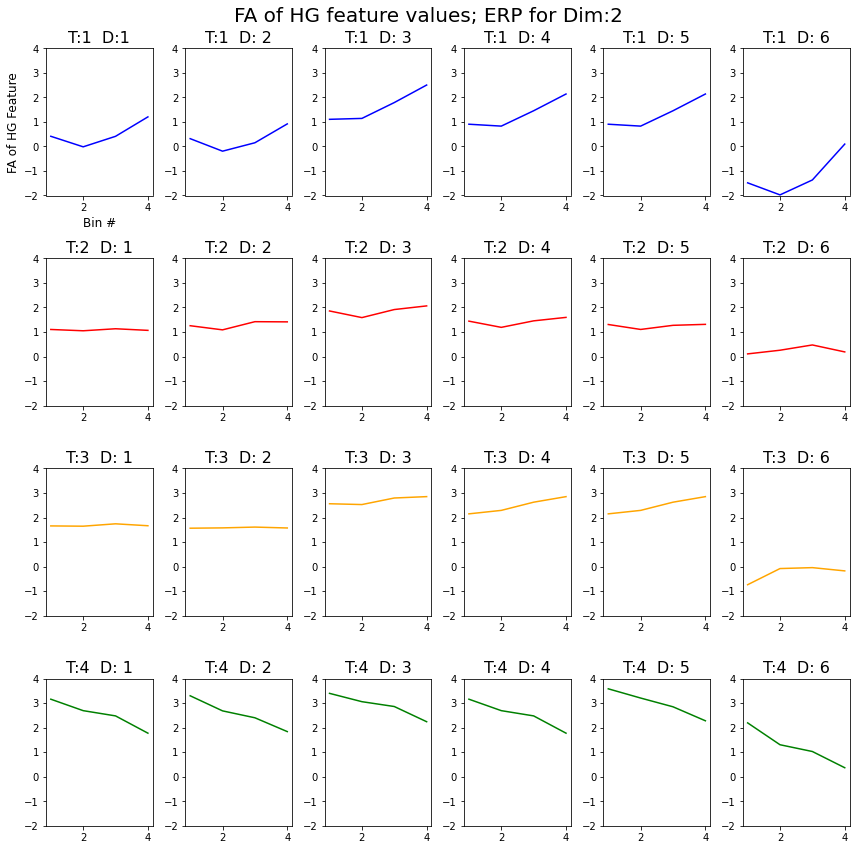

In [62]:
# the inputs will be FA signals

HGFA_T1 = FASignal[0].Target
HGFA_T2 = FASignal[1].Target
HGFA_T3 = FASignal[2].Target
HGFA_T4 = FASignal[3].Target


# for target 1
# initilize the values
class structtype():
    pass

SingleTrials_T1 = [ structtype() for i in range(len(Day_NumTrial_T1))]
ERP_T1 = [ structtype() for i in range(len(Day_NumTrial_T1))]

BinNum_ERP = int(max(Click_BinNum_T1))
for i in range(len(Day_NumTrial_T1)):
    Temp = np.empty((BinNum_ERP,10,Day_NumTrial_T1[i]), dtype=float)
    Temp[:]=np.nan 

    for j in range(Day_NumTrial_T1[i]):
        if j == 0:
            Temp[0:int(Click_BinNum_T1[j]),:,j] = HGFA_T1[0:int(Click_BinNum_T1[j]),:]
            
    
        else:
            Temp[0:int(Click_BinNum_T1[j]),:,j] = HGFA_T1[int(sum(Click_BinNum_T1[0:(j-1)])):int(sum(Click_BinNum_T1[0:(j-1)]))+int(Click_BinNum_T1[j]),:]
            
    SingleTrials_T1[i].Day = Temp
    ERP_T1[i].Day = np.nanmean(Temp, axis=2)

# for target 2
# initilize the values
class structtype():
    pass

SingleTrials_T2 = [ structtype() for i in range(len(Day_NumTrial_T2))]
ERP_T2 = [ structtype() for i in range(len(Day_NumTrial_T2))]

BinNum_ERP = int(max(Click_BinNum_T2))
for i in range(len(Day_NumTrial_T2)):
    Temp = np.empty((BinNum_ERP,10,Day_NumTrial_T2[i]), dtype=float)
    Temp[:]=np.nan  

    for j in range(Day_NumTrial_T2[i]):
        if j == 0:
            Temp[0:int(Click_BinNum_T2[j]),:,j] = HGFA_T2[0:int(Click_BinNum_T2[j]),:]
            
    
        else:
            Temp[0:int(Click_BinNum_T1[j]),:,j] = HGFA_T2[int(sum(Click_BinNum_T2[0:(j-1)])):int(sum(Click_BinNum_T2[0:(j-1)]))+int(Click_BinNum_T2[j]),:]
            
    SingleTrials_T2[i].Day = Temp
    ERP_T2[i].Day = np.nanmean(Temp, axis=2)
    
# for target 3
# initilize the values
class structtype():
    pass

SingleTrials_T3 = [ structtype() for i in range(len(Day_NumTrial_T3))]
ERP_T3 = [ structtype() for i in range(len(Day_NumTrial_T3))]

BinNum_ERP = int(max(Click_BinNum_T3))
for i in range(len(Day_NumTrial_T3)):
    Temp = np.empty((BinNum_ERP,10,Day_NumTrial_T3[i]), dtype=float)
    Temp[:]=np.nan 

    for j in range(Day_NumTrial_T3[i]):
        if j == 0:
            Temp[0:int(Click_BinNum_T3[j]),:,j] = HGFA_T3[0:int(Click_BinNum_T3[j]),:]
            
    
        else:
            Temp[0:int(Click_BinNum_T3[j]),:,j] = HGFA_T3[int(sum(Click_BinNum_T3[0:(j-1)])):int(sum(Click_BinNum_T3[0:(j-1)]))+int(Click_BinNum_T3[j]),:]
            
    SingleTrials_T3[i].Day = Temp
    ERP_T3[i].Day = np.nanmean(Temp, axis=2)
    
# for target 4
# initilize the values
class structtype():
    pass

SingleTrials_T4 = [ structtype() for i in range(len(Day_NumTrial_T4))]
ERP_T4 = [ structtype() for i in range(len(Day_NumTrial_T4))]

BinNum_ERP = int(max(Click_BinNum_T4))
for i in range(len(Day_NumTrial_T4)):
    Temp = np.empty((BinNum_ERP,10,Day_NumTrial_T4[i]), dtype=float)
    Temp[:]=np.nan 

    for j in range(Day_NumTrial_T4[i]):
        if j == 0:
            Temp[0:int(Click_BinNum_T4[j]),:,j] = HGFA_T4[0:int(Click_BinNum_T4[j]),:]
            
    
        else:
            Temp[0:int(Click_BinNum_T4[j]),:,j] = HGFA_T4[int(sum(Click_BinNum_T4[0:(j-1)])):int(sum(Click_BinNum_T4[0:(j-1)]))+int(Click_BinNum_T4[j]),:]
            
    SingleTrials_T4[i].Day = Temp
    ERP_T4[i].Day = np.nanmean(Temp, axis=2)
    

# plot the ERP for a chosen Dim

%matplotlib inline

ListMarker = ['blue','red','orange','green']
Dim = 2

fig, axes = plt.subplots(4,6,figsize=(12,12))
fig.suptitle('FA of HG feature values; ERP for Dim:'+str(Dim), fontsize=20)

ERP_All = [ERP_T1, ERP_T2, ERP_T3, ERP_T4]

for target in range(4):
    ERP_AllDay = ERP_All[target]
    
    for ax in range(6):
        ERP_plot = ERP_AllDay[ax].Day
        t_bin = np.arange(1,ERP_plot.shape[0]+1,1)
        if target == 0 and ax == 0:
            axes[target, ax].plot(t_bin,ERP_plot[:,Dim],color=ListMarker[target])
            axes[target, ax].set_title('T:'+str(target+1)+'  D:'+str(ax+1),fontsize=16)
            axes[target, ax].set_xlabel('Bin #',fontsize=12)
            axes[target, ax].set_ylabel('FA of HG Feature',fontsize=12)
            axes[target, ax].set_ylim([-2,4])
            
        else:
            axes[target, ax].plot(t_bin,ERP_plot[:,Dim],color=ListMarker[target])
            axes[target, ax].set_title('T:'+str(target+1)+'  D: '+str(ax+1),fontsize=16)
            axes[target, ax].set_ylim([-2,4])
            
plt.tight_layout()
plt.savefig('ERP_Bins_hgFA_DeMean_6Days_Dim2.png',dpi=300)
 
    

# Selecting the input for SVM analysis

In [145]:
# Run the linear SVM for these inputs

# first chose: only HG values without any de-mean and FA; 128 dimensions
# second chose: Latent factors of de-mean HG; 10 factors
# third chose: calculate the reconstructed de-noised HG
# forth chose: calculate the residual value/ privare variance out of FA  

CaseSVM = 4


if CaseSVM == 1:
    X_T1 = HG_T1
    X_T2 = HG_T2
    X_T3 = HG_T3
    X_T4 = HG_T4
    
elif CaseSVM == 2:
    X_T1 = FASignal[0].Target
    X_T2 = FASignal[1].Target
    X_T3 = FASignal[2].Target
    X_T4 = FASignal[3].Target

elif CaseSVM == 3:
    X_T1 = (FASignal[0].Target) @ (FAWeight.T)
    X_T2 = (FASignal[1].Target) @ (FAWeight.T)
    X_T3 = (FASignal[2].Target) @ (FAWeight.T)
    X_T4 = (FASignal[3].Target) @ (FAWeight.T)
    
elif CaseSVM == 4: 
    X_Rec_T1 = (FASignal[0].Target) @ (FAWeight.T)
    X_Rec_T2 = (FASignal[1].Target) @ (FAWeight.T)
    X_Rec_T3 = (FASignal[2].Target) @ (FAWeight.T)
    X_Rec_T4 = (FASignal[3].Target) @ (FAWeight.T)
    
    X_T1 = HG_T1-X_Rec_T1
    X_T2 = HG_T2-X_Rec_T2
    X_T3 = HG_T3-X_Rec_T3
    X_T4 = HG_T4-X_Rec_T4
    
    



In [146]:
X_T1.shape

(650, 128)

# Performing multi-classifier SVM 


In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# balance the data
Indx = min(X_T1.shape[0], X_T2.shape[0],X_T3.shape[0],X_T4.shape[0])
step = 1
KeepSample = 50 

X_heldout_T1 = X_T1[(Indx-KeepSample):Indx:step,:]
X_heldout_T2 = X_T2[(Indx-KeepSample):Indx:step,:]
X_heldout_T3 = X_T3[(Indx-KeepSample):Indx:step,:]
X_heldout_T4 = X_T4[(Indx-KeepSample):Indx:step,:]


y_heldout_T1 = np.zeros((X_heldout_T1.shape[0],1))
y_heldout_T2 = np.ones((X_heldout_T2.shape[0],1))
y_heldout_T3 = 2*np.ones((X_heldout_T3.shape[0],1))
y_heldout_T4 = 3*np.ones((X_heldout_T4.shape[0],1))


X_heldout = np.concatenate((X_heldout_T1, X_heldout_T2, X_heldout_T3, X_heldout_T4), axis=0) 
y_heldout = np.concatenate((y_heldout_T1, y_heldout_T2, y_heldout_T3, y_heldout_T4), axis=0)
# flatten the array
y_heldout =y_heldout.ravel()

X_T1 = X_T1[0:(Indx-KeepSample):step,:]
X_T2 = X_T2[0:(Indx-KeepSample):step,:]
X_T3 = X_T3[0:(Indx-KeepSample):step,:]
X_T4 = X_T4[0:(Indx-KeepSample):step,:]

y_T1 = np.zeros((X_T1.shape[0],1))
y_T2 = np.ones((X_T2.shape[0],1))
y_T3 = 2*np.ones((X_T3.shape[0],1))
y_T4 = 3*np.ones((X_T4.shape[0],1))

X = np.concatenate((X_T1, X_T2, X_T3, X_T4), axis=0) 
y = np.concatenate((y_T1, y_T2, y_T3, y_T4), axis=0)
# flatten the array
y =y.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [148]:
X_train.shape

(1516, 128)

In [149]:
from sklearn.svm import SVC
model_multi = SVC(C=1, kernel='linear', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)
model_multi.fit(X_train,y_train)
SVC()

SVC()

In [150]:
# get support vectors
NumSV = model_multi.support_vectors_
NumSV.shape

(491, 128)

In [151]:
from sklearn.metrics import classification_report, confusion_matrix

# testing the trainig result
predictions_multi = model_multi.predict(X_test)
print(confusion_matrix(y_test, predictions_multi))
print('\n')
print(classification_report(y_test, predictions_multi))


[[185   0  11   3]
 [  1 155  10  16]
 [  5   9 152   6]
 [  3  21   8 163]]


              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94       199
         1.0       0.84      0.85      0.84       182
         2.0       0.84      0.88      0.86       172
         3.0       0.87      0.84      0.85       195

    accuracy                           0.88       748
   macro avg       0.87      0.88      0.87       748
weighted avg       0.88      0.88      0.88       748



In [152]:
# testing the held_out data
predictions_heldout_multi = model_multi.predict(X_heldout)
print(confusion_matrix(y_heldout, predictions_heldout_multi))
print('\n')
print(classification_report(y_heldout, predictions_heldout_multi))

[[50  0  0  0]
 [ 0 46  4  0]
 [ 2  2 46  0]
 [ 0  3  8 39]]


              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        50
         1.0       0.90      0.92      0.91        50
         2.0       0.79      0.92      0.85        50
         3.0       1.00      0.78      0.88        50

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.90       200
weighted avg       0.91      0.91      0.90       200



# Parameter adjustment for multi-classifier SVM

In [45]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C':[0.1, 1, 10, 100, 1000], 'gamma':[1, 0.1, 0.01, 0.001, 0.0001]}
grid_multi = GridSearchCV(model_multi,param_grid, verbose=3)
grid_multi.fit(X_train,y_train)

SyntaxError: positional argument follows keyword argument (<ipython-input-45-6c7624ec61ea>, line 4)

In [35]:
grid_multi.best_params_

{'C': 0.1, 'gamma': 1}

In [36]:
predictions_grid_multi = grid_multi.predict(X_test)

In [37]:
print(confusion_matrix(y_test, predictions_grid_multi))
print('\n')
print(classification_report(y_test,predictions_grid_multi))

[[207   0   9   3]
 [  0 178  10  15]
 [  4   3 189   6]
 [  4  20   8 158]]


              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95       219
         1.0       0.89      0.88      0.88       203
         2.0       0.88      0.94      0.90       202
         3.0       0.87      0.83      0.85       190

    accuracy                           0.90       814
   macro avg       0.90      0.90      0.90       814
weighted avg       0.90      0.90      0.90       814



In [38]:
# testing the held_out data
predictions_heldout_multi = grid_multi.predict(X_heldout)
print(confusion_matrix(y_heldout, predictions_heldout_multi))
print('\n')
print(classification_report(y_heldout, predictions_heldout_multi))

[[49  0  1  0]
 [ 0 50  0  0]
 [ 1  3 46  0]
 [ 0  3  0 47]]


              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98        50
         1.0       0.89      1.00      0.94        50
         2.0       0.98      0.92      0.95        50
         3.0       1.00      0.94      0.97        50

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200

